In [62]:
import os
import six.moves.cPickle as pickle
import gzip
import numpy as np
import theano
import theano.tensor as T
from theano.tensor.nnet import conv2d, conv2d_transpose
from theano.tensor.signal import pool
from theano.sandbox.rng_mrg import MRG_RandomStreams as RandomStreams
theano.config.optimizer='fast_compile'
theano.config.exception_verbosity='high'
theano.config.compute_test_value = 'off'
theano.config.floatX = 'float32'
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

In [63]:
# create shared variables for using gpu
def shared_dataset(data, borrow=True, data_types=['float32','int32']):
    if type(data) is not list:
        data = list(data)
    output = []
    for i, x in enumerate(data):
        output.append(theano.shared(np.asarray(x, dtype=data_types[i]), borrow=borrow))
    return output

def load_dataset(dataset):
    # get path/file for dataset
    data_dir, data_file = os.path.split(dataset)
    if data_dir == "" and not os.path.isfile(dataset):
        # Check if dataset is in the current directory.
        new_path = os.path.join(os.curdir, dataset)
        if os.path.isfile(new_path) or data_file == 'mnist.pkl.gz':
            dataset = new_path
    # download from website
    if (not os.path.isfile(dataset)) and data_file == 'mnist.pkl.gz':
        from six.moves import urllib
        origin = ('http://www.iro.umontreal.ca/~lisa/deep/data/mnist/mnist.pkl.gz')
        print('Downloading data from %s' % origin)
        urllib.request.urlretrieve(origin, dataset)
    # load from pickle
    print('... loading data')
    with gzip.open(dataset, 'rb') as f:
        try:
            train_set, valid_set, test_set = pickle.load(f, encoding='latin1')
        except:
            train_set, valid_set, test_set = pickle.load(f)
    # set test/valid/train sets
    test_set_x, test_set_y = shared_dataset(test_set)
    valid_set_x, valid_set_y = shared_dataset(valid_set)
    train_set_x, train_set_y = shared_dataset(train_set)
    # combine datasets
    rval = [(train_set_x, train_set_y), (valid_set_x, valid_set_y), (test_set_x, test_set_y)]
    return rval

In [202]:
class HelmholtzLayer(object):
    '''
    Helmholtz layer for Helmholtz Machine
    
    Parameters
    ----------
    input: theano matrix, input to layer (data or output of previous layer)
    n_in: int, number of input units
    n_out: int, number of hidden units
    unit: str, hidden unit type ['binary' (default) or 'gaussian']
    th_rng: theano RandomStreams, random generator for sampling
    top_layer: bool, True/False layer is top layer
    sparse_thr: float, fraction of most active units for K-max WTA; less active units are set to 0
        [default: 0., no units set to 0]
    
    Returns
    -------
    HelmholtzLayer
    '''
    def __init__(self, input, n_in, n_out, unit='binary', th_rng=None, top_layer=False, sparse_thr=0.):
        # init vars
        self.input = input
        self.n_in = n_in
        self.n_out = n_out
        self.unit = unit
        # init th_rng if None
        if th_rng is None:
            self.th_rng = RandomStreams(1)
        else:
            self.th_rng = th_rng
        self.top_layer = top_layer
        self.sparse_thr = sparse_thr
        
        # recognition weights
        self.WR = theano.shared(np.asarray(np.random.normal(scale=0.01, size=(n_in,n_out)),
                                           dtype=theano.config.floatX),
                                borrow=True, name='WR')
        # recognition biases
        self.bR = theano.shared(np.zeros((n_out,), dtype=theano.config.floatX), 
                                borrow=True, name='bR')
        # generative weights
        self.WG = theano.shared(np.asarray(np.random.normal(scale=0.01, size=(n_out,n_in)),
                                           dtype=theano.config.floatX),
                                borrow=True, name='WG')
        # generative biases
        self.bG = theano.shared(np.zeros((n_in,), dtype=theano.config.floatX),
                                borrow=True, name='bG')
        
        # momentum
        self.inc_WR = theano.shared(np.zeros((n_in,n_out), dtype=theano.config.floatX),
                                    borrow=True, name='inc_WR')
        self.inc_bR = theano.shared(np.zeros((n_out,), dtype=theano.config.floatX),
                                    borrow=True, name='inc_bR')
        self.inc_WG = theano.shared(np.zeros((n_out,n_in), dtype=theano.config.floatX),
                                    borrow=True, name='inc_WG') 
        self.inc_bG = theano.shared(np.zeros((n_in,), dtype=theano.config.floatX),
                                    borrow=True, name='inc_bG')
        
        # if top_layer, remove shared WR, bR, WG
        if self.top_layer:
            self.WR = T.zeros_like(self.WR)
            self.bR = T.zeros_like(self.bR)
            self.WG = T.zeros_like(self.WG)
            # set gen_params, rec_params
            self.gen_params = [self.bG]
            self.rec_params = []
            self.inc_params = [self.inc_bG]
        else:
            # set gen_params, rec_params
            self.gen_params = [self.WG, self.bG]
            self.rec_params = [self.WR, self.bR]
            self.inc_params = [self.inc_WG, self.inc_bG, self.inc_WR, self.inc_bR]
        
        # set output
        self.output = self.sample_h_given_v(self.input)
        
        # init reconstr, top_down
        self.reconstr = None
        self.top_down = None
        
    def activation(self, u, unit):
        if unit == 'binary':
            y = T.nnet.sigmoid(u)
        elif unit == 'gaussian':
            y = u
        else: # throw error
            raise NotImplementedError
        return y
    
    def sample(self, u, unit):
        if unit == 'binary':
            y = self.th_rng.binomial(size=u.shape, n=1, p=u, dtype=theano.config.floatX)
        elif unit == 'gaussian':
            y = T.add(u, self.th_rng.normal(u.shape, std=1., dtype=theano.config.floatX))
        else: # throw error
            raise NotImplementedError
        return y
    
    def prob(self, u, unit):
        if unit == 'binary':
            p = u
        elif unit == 'gaussian':
            p = (1./T.sqrt(2. * np.pi)) * T.exp(-T.sqr(u)/2.)
        else: # throw error
            raise NotImplementedError
        return p
    
    def propup(self, v):
        pre_act_h = T.dot(v, self.WR) + self.bR
        return self.activation(pre_act_h, self.unit)
    
    def propdown(self, h):
        pre_act_v = T.dot(h, self.WG) + self.bG
        return self.activation(pre_act_v, self.unit)
    
    def sample_h_given_v(self, v):
        h_mean = self.propup(v)
        # if sparse_thr, apply
        h_mean = self.sparse_threshold(h_mean, self.sparse_thr)
        return self.sample(h_mean, self.unit)
    
    def sample_v_given_h(self, h):
        v_mean = self.propdown(h)
        # if sparse_thr, apply
        v_mean = self.sparse_threshold(v_mean, self.sparse_thr)
        return self.sample(v_mean, self.unit)
    
    def get_wake_derivs(self):
        # get delta by propagating down with output
        delta = self.propdown(self.output)
        
        # get wake derivatives
        dWG = T.dot(self.output.T, (self.input - delta))/T.cast(self.input.shape[0], dtype=theano.config.floatX)
        dbG = T.mean((self.input - delta), axis=0)
        
        # if top_layer, no WG derivs
        if self.top_layer:
            return [dbG]
        else:
            return [dWG, dbG]
        
    def get_sleep_derivs(self):
        # if top_layer, no sleep derivs
        if self.top_layer:
            return []
        
        # get psi by propagating up with reconstr
        psi = self.propup(self.reconstr)
        
        # get sleep derivatives
        dWR = T.dot(self.reconstr.T, (self.top_down - psi))/T.cast(self.reconstr.shape[0], dtype=theano.config.floatX)
        dbR = T.mean((self.top_down - psi), axis=0)
        return [dWR, dbR]
    
    def switch_awake(self, awake):
        # set x,y based on wake or sleep
        x = theano.gradient.disconnected_grad(T.switch(T.zeros_like(self.input) + awake,
                                                       self.input, self.reconstr))
        y = theano.gradient.disconnected_grad(T.switch(T.zeros_like(self.output) + awake,
                                                       self.output, self.top_down))
        return x, y
    
    def prob_qp(self, awake):
        # get x, y
        x, y = self.switch_awake(awake)
        # compute q and p
        q = self.prob(self.propup(x), self.unit)
        p = self.prob(self.propdown(y), self.unit)
        return q, p
    
    def log_prob(self, awake):
        # get x, y
        x, y = self.switch_awake(awake)
        # get probs
        q, p = self.prob_qp(awake)
        # compute log probs
        log_q = T.sum(T.add(y * T.log(q + 1e-6), (1. - y) * T.log(1. - q + 1e-6)), axis=1)
        log_p = T.sum(T.add(x * T.log(p + 1e-6), (1. - x) * T.log(1. - p + 1e-6)), axis=1)
        return log_q, log_p
    
    def sparsity(self, t, s, awake, params):
        q, p = self.prob_qp(awake)
        q = T.mean(q, axis=0)
        p = T.mean(p, axis=0)
        cost = s * T.add(T.sum(t * T.log(q + 1e-6) + (1. - t) * T.log(1. - q + 1e-6)),
                         T.sum(t * T.log(p + 1e-6) + (1. - t) * T.log(1. - p + 1e-6)))
        return T.grad(-cost, params)
    
    def sparse_threshold(self, x, thr):
        # get threshold and repeat across axis=1
        thr = T.sort(T.abs_(x))[:, -T.cast(thr * x.shape[1], 'int32')].dimshuffle((0,'x'))
        thr = T.repeat(thr, x.shape[1], axis=1)
        # set values >= thr to x, values <= thr to 0
        return T.switch(T.ge(T.abs_(x), thr), x, T.zeros_like(x))
    
    def set_reconstr(self, top_down):
        self.top_down = top_down
        self.reconstr = self.sample_v_given_h(self.top_down)

In [203]:
class HelmholtzMachine(object):
    '''
    Helmholtz machine
    
    Parameters
    ----------
    n_ins: list of ints, number of inputs for each layer
    unit: str, unit type ['binary' (default) or 'gaussian']
    th_rng: theano RandomStreams, random generator for sampling
    
    Returns
    -------
    HelmholtzMachine
    '''
    def __init__(self, n_ins, unit='binary', th_rng=None, sparse_thr=0.):
        # init vars
        self.n_layers = len(n_ins)
        self.n_ins = n_ins
        self.unit = unit
        if th_rng is None:
            self.th_rng = RandomStreams(np.random.randint(2**30))
        else:
            self.th_rng = th_rng
        self.sparse_thr = sparse_thr
            
        # init first layer input variable
        self.v = T.matrix('v')
        
        # for each layer, append HelmholtzLayer
        self.helmholtz_layers = []
        for n in range(self.n_layers):
            # set bG_1 to True if top layer, False otherwise
            is_top_layer = (n == self.n_layers - 1)
            # set input_layer
            if n == 0:
                input_layer = self.v
            else:
                input_layer = self.helmholtz_layers[-1].output
            # set n_out
            if is_top_layer:
                n_out = 1
            else:
                n_out = self.n_ins[n+1]
            # create helmholtz layer
            self.helmholtz_layers.append(HelmholtzLayer(input_layer, 
                                                         self.n_ins[n], 
                                                         n_out,
                                                         unit=self.unit,
                                                         th_rng=self.th_rng,
                                                         top_layer=is_top_layer,
                                                         sparse_thr=self.sparse_thr))
            
        # for each layer, set reconstr
        for n in range(self.n_layers-1, -1, -1):
            # for top layer, top_down is zeros
            if n == self.n_layers-1:
                top_down = T.zeros((1,1), dtype=theano.config.floatX)
            else:
                top_down = self.helmholtz_layers[n+1].reconstr
            # set top_down and reconstr
            self.helmholtz_layers[n].set_reconstr(top_down)
    
    def model_sample(self):
        return self.helmholtz_layers[0].reconstr[0]
    
    def model_prob(self):
        layer0 = self.helmholtz_layers[0]
        return layer0.prob(layer0.propdown(layer0.top_down), layer0.unit)
    
    def free_energy_part(self, q, p):
        return T.sum(T.add(q * (T.log(q + 1e-6) - T.log(p + 1e-6)),
                           (1. - q) * (T.log(1. - q + 1e-6) - T.log(1. - p + 1e-6))))
    
    def free_energy(self, D=None, awake=T.cast(1., 'int32'), params=[]):
        FEs = []
        if D is None:
            return_fn = True
            D = T.matrix('D')
        else:
            return_fn = False
            
        # compute FE for each layer
        FEs.append(self.free_energy_part(D, self.helmholtz_layers[0].prob_qp(awake)[1]))
        for n in range(1, self.n_layers):
            FEs.append(self.free_energy_part(self.helmholtz_layers[n-1].prob_qp(awake)[0],
                                             self.helmholtz_layers[n].prob_qp(awake)[1]))
        
        # return function that can compute FE for given data
        if return_fn:
            return theano.function([D], T.sum(FEs), givens={self.v: D})
        else:
            return T.grad(-T.sum(FEs), params)
       
    def importance_weighting(self, log_q, log_p):
        # from Bornschein et al., 2016
        # w = sqrt(p/q)
        log_w = (log_p - log_q) / 2.
        # w_sum = sum_k(log_pq)
        log_w_max = T.max(log_w, axis=1, keepdims=True)
        log_w_sum = T.log(T.sum(T.exp(log_w - log_w_max), axis=1, keepdims=True)) + log_w_max
        # w_norm = w/w_sum
        log_w_norm = log_w - log_w_sum
        # w = exp(log_w_norm)
        return T.exp(log_w_norm)
    
    def log_likelihood(self, D=None, awake=T.cast(1., 'int32'), params=[]):
        log_qs = []
        log_ps = []
        if D is None:
            return_fn = True
            D = T.matrix('D')
        else:
            return_fn = False
            
        # get log_q, log_p for each layer
        for n in range(self.n_layers):
            log_q_n, log_p_n = self.helmholtz_layers[n].log_prob(awake)
            log_qs.append(log_q_n)
            log_ps.append(log_p_n)
            
        # sum across layers
        log_q = T.sum(log_qs, axis=0)
        log_p = T.sum(log_ps, axis=0)
        
        # reshape to (batch_size, n_samples)
        log_q = T.reshape(log_q, (D.shape[0]//self.n_samples, self.n_samples)) 
        log_p = T.reshape(log_p, (D.shape[0]//self.n_samples, self.n_samples))
        
        # get importance weights
        w = self.importance_weighting(log_q, log_p)
        
        # compute log likelihood
        log_pq = (log_p - log_q) / 2.
        w_norm = T.log(w + 1e-6) - log_pq
        LL = w_norm - T.log(self.n_samples)
        
        # cost
        cost = T.sum(w * (log_p + log_q))
            
        # return theano function or LL
        if return_fn:
            return theano.function([D], -LL, givens={self.v: D})
        else:
            return T.grad(cost, params)
        
    def save_model(self, file_name):
        with open(file_name, 'wb') as f:
            pickle.dump(self, f)
        
    def train_function(self, train_data, batch_size, cost_type='free_energy', 
                       opts={'momentum': False, 'sparsity': False, 'sparsity_cost': 1., 
                             'sparsity_target': 0.001, 'n_samples': 1, 'auto_derivs': True}):
        '''
        Create training function with given update rule, momentum, and sparsity
        
        Parameters
        ----------
        train_data: theano matrix, training data to use
        batch_size: int, size of each training mini-batch
        cost_type: str, cost type to use for update rule ['free_energy' (default) or 'log_likelihood']
        opts: dict, options for momentum, sparsity, importance sampling, and automatic differentiation
            'momentum': bool, True/False use momentum [default: False]
            'sparsity': bool, True/False use sparsity [default: False]
            'sparsity_cost': float, scalar to multiply sparsity cost [default: 1.]
            'sparsity_target': float, target sparsity for hidden activities [default: 0.001]
            'n_samples': int, number of samples to use for importance sampling [default: 1] (cost_type='loglikelihood')
            'auto_derivs': bool, True/False use automatic differentiation [default: True] (cost_type='free_energy')
            
        Returns
        -------
        train_fn: theano function, training function with following inputs
            idx: int, index of training mini-batch (i.e. train_data[idx*batch_size:(idx+1)*batch_size])
            awake: bool, True/False awake for wake/sleep algorithm
            m: float, momentum to apply (only if opts['momentum'] == True)
            *lr: float(s), learning rates for each layer
        '''
        # init vars
        awake = T.iscalar('awake').astype(theano.config.floatX)
        lr = [T.scalar('lr_' + str(n)) / batch_size for n in range(self.n_layers)]
        idx = T.iscalar('idx')
        v = train_data[idx * batch_size:(idx + 1) * batch_size]
        
        # momentum options
        if 'momentum' in opts:
            momentum = opts['momentum']
        else:
            momentum = False
        if momentum:
            m = T.scalar('m')
        else:
            m = 0.
        # sparsity options
        if 'sparsity' in opts:
            sparsity = opts['sparsity']
        else:
            sparsity = False
        if 'spasity_cost' in opts:
            sparsity_cost = opts['sparsity_cost']
        elif sparsity:
            sparsity_cost = 1.
        if 'sparsity_target' in opts:
            sparsity_target = opts['sparsity_target']
        else:
            sparsity_target = 0.001
        # n_samples (add to self so log_likelihood() has access)
        if 'n_samples' in opts and cost_type == 'log_likelihood':
            self.n_samples = opts['n_samples']
        else:
            self.n_samples = 1
        # automatic differentiation
        if 'auto_derivs' in opts:
            auto_derivs = opts['auto_derivs']
        else:
            auto_derivs = True
            
        # get gradient function
        if cost_type == 'free_energy':
            print('Cost: free energy (automatic differentiation: %s)' % (auto_derivs))
            grad_fn = self.free_energy
        elif cost_type == 'log_likelihood':
            print('Cost: log likelihood (n_samples: %d)' % (self.n_samples))
            v = T.repeat(v, self.n_samples, axis=0)
            grad_fn = self.log_likelihood
            auto_derivs = True
        
        # parameter updates for theano function
        updates = []
        for n in range(self.n_layers):
            if auto_derivs: # automatic derivatives
                wake_derivs = grad_fn(v, awake, self.helmholtz_layers[n].gen_params)
                sleep_derivs = grad_fn(v, awake, self.helmholtz_layers[n].rec_params)
            else: # manual derivatives
                wake_derivs = self.helmholtz_layers[n].get_wake_derivs()
                sleep_derivs = self.helmholtz_layers[n].get_sleep_derivs()
                
            # sparsity
            if sparsity:
                wake_sparse = self.helmholtz_layers[n].sparsity(sparsity_target, sparsity_cost,
                                                                awake, self.helmholtz_layers[n].gen_params)
                wake_derivs = [g + s for g, s in zip(wake_derivs, wake_sparse)]
                sleep_sparse = self.helmholtz_layers[n].sparsity(sparsity_target, sparsity_cost,
                                                                 awake, self.helmholtz_layers[n].rec_params)
                sleep_derivs = [g + s for g, s in zip(sleep_derivs, sleep_sparse)]
                
            # wake phase
            for param, gparam, inc_param in zip(self.helmholtz_layers[n].gen_params, wake_derivs,
                                                self.helmholtz_layers[n].inc_params[:2]):
                updates.append((param, param + awake * lr[n] * gparam + inc_param * m))
                # momentum
                if momentum:
                    updates.append((inc_param, awake * (inc_param * m + lr[n] * gparam)))
                
            # sleep phase
            sleep_derivs = self.helmholtz_layers[n].get_sleep_derivs()
            for param, gparam, inc_param in zip(self.helmholtz_layers[n].rec_params, sleep_derivs,
                                                self.helmholtz_layers[n].inc_params[2:]):
                updates.append((param, param + (1. - awake) * lr[n] * gparam + inc_param * m))
                # momentum
                if momentum:
                    updates.append((inc_param, (1. - awake) * (inc_param * m + lr[n] * gparam)))
        
        # create train_fn
        if momentum:
            inputs = [idx, awake, m] + lr
        else:
            inputs = [idx, awake] + lr
        train_fn = theano.function(inputs, [], updates=updates, givens={self.v: v})
           
        return train_fn

In [12]:
data = load_dataset('mnist.pkl.gz')[0][0]
# data = T.gt(data, 0.5).astype('float32')

... loading data


In [ ]:
# create bar data
data = np.zeros((1000, 3, 3), dtype=theano.config.floatX)
for n in range(data.shape[0]):
    # Horizontal bars 1/3, vertical bars 2/3
    if np.random.rand() > (2./3.): 
        data[n, np.random.randint(data.shape[1]), :] = 1.
    else:
        data[n, :, np.random.randint(data.shape[2])] = 1.
data = np.reshape(data, (data.shape[0], -1))
data = T.as_tensor(data)

In [205]:
# initialize helmholtz machine
helm = HelmholtzMachine([784, 500, 10], unit='binary', sparse_thr=0.2) #[9,6,1]
# create training and cost monitoring functions
batch_size = 10
opts = {'momentum': True, 'sparsity': False, 'auto_derivs': False} #, 'sparsity_cost': 0.5, 'sparsity_target': 0.001, 'n_samples': 10}
train_fn = helm.train_function(data, batch_size, cost_type='free_energy', opts=opts)
cost_fn = helm.free_energy()

Cost: free energy (automatic differentiation: False)


'Epoch 18 (10.00%): 581403.6250'

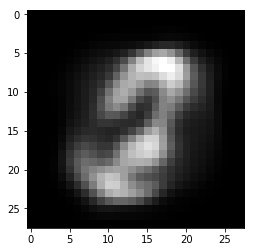

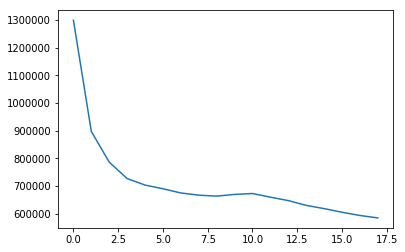

In [ ]:
# train
lr = [1e-3]*helm.n_layers
n_batches = data.eval().shape[0]//batch_size
monitor = n_batches//10 # monitor every 10%
cost_history = []
im_size = (28,28)

# train in epochs
for epoch in range(50):
    # momentum
    if epoch < 5:
        m = 0.5
    else:
        m = 0.9
    cost = []
    # for each batch_size within n_batches, train
    for n in range(n_batches):
        train_fn(n, True, m, *lr) # wake phase
        train_fn(n, False, m, *lr) # sleep phase
        
        # monitor samples
        if n % monitor == 0:
            # get cost for random set of mini-batches
            rand_idxs = np.random.permutation(data.eval().shape[0])
            cost.append(cost_fn(data[rand_idxs[:monitor*batch_size]].eval()))
            
            # print progress
            clear_output(wait=True)
            display('Epoch %d (%0.2f%%): %0.4f' % (epoch, 100. * n/n_batches, np.mean(cost)))
            
            # plot sample (sigmoid) from model
            plt.imshow(helm.model_prob().eval().reshape(im_size), cmap='gray')
            plt.show()
            
            # plot cost history
            plt.plot(cost_history)
            plt.show()
            
    # append cost history
    cost_history.append(np.mean(cost))

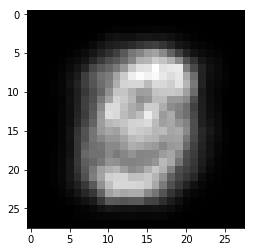

In [201]:
# show samples (sigmoid) from model
plt.imshow(helm.model_prob().eval().reshape(im_size), cmap='gray')
plt.show()